In [1]:
# !pip install tf-models-official
# !pip install tfds-nightly

In [2]:
# Imports
import os
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from typing import Any

# Only let TensorFlow allocate RAM as needed
physical_devices = tf.config.experimental.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Configuration
tf.random.set_seed(0)
batch_size = 64
seq_len = 128
mnli_ds_name = "multi_nli"
sentence_features = ["hypothesis", "premise"]
num_classes = 3
bert_encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
export_dir = "saved_model"

2022-10-31 02:02:12.038458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 02:02:12.386834: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def build_bert_preprocessor(sentence_features: "list[str]", seq_length: int = 128) -> tf.keras.Model:
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocessor_url)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name="packer")
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

In [4]:
def get_data_from_dataset(full_dataset: "dict[Any, tf.data.Dataset]", info: tfds.core.DatasetBuilder, split: str,
                          batch_size: int, bert_preprocessor: tf.keras.Model) -> "tuple[tf.data.Dataset, int]":
    is_training = split.startswith("train")
    dataset = tf.data.Dataset.from_tensor_slices(full_dataset[split])
    num_examples = info.splits[split].num_examples

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocessor(ex), ex["label"]))
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, num_examples

In [5]:
def build_bert_classifier(num_classes: int) -> tf.keras.Model:
    class Classifier(tf.keras.Model):
        def __init__(self, num_classes):
            super(Classifier, self).__init__(name="prediction")
            self.encoder = hub.KerasLayer(bert_encoder_url, trainable=True)
            self.dropout = tf.keras.layers.Dropout(0.1)
            self.dense = tf.keras.layers.Dense(num_classes)

        def call(self, preprocessed_text):
            encoder_outputs = self.encoder(preprocessed_text)
            pooled_output = encoder_outputs["pooled_output"]
            x = self.dropout(pooled_output)
            x = self.dense(x)
            return x

    model = Classifier(num_classes)
    return model

In [6]:
bert_preprocessor = build_bert_preprocessor(sentence_features, seq_length=seq_len)

# Create train and validation data
mnli_ds: "dict[tfds.Split, tf.data.Dataset]" = tfds.load(mnli_ds_name, batch_size=-1, shuffle_files=True)  # type: ignore
mnli_ds_info = tfds.builder(mnli_ds_name).info

train_data, train_data_size = get_data_from_dataset(mnli_ds, mnli_ds_info,
    "train", batch_size, bert_preprocessor)
steps_per_epoch = train_data_size // batch_size

validation_data, validation_data_size = get_data_from_dataset(mnli_ds, mnli_ds_info,
    "validation_matched", batch_size, bert_preprocessor)
validation_steps = validation_data_size // batch_size

2022-10-31 02:02:22.249496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 02:02:23.331418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


2022-10-31 02:02:25.202708: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/392702 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/multi_nli/1.1.0.incompleteDLU44F/multi_nli-train.tfrecord*...:   0%|      …

Generating validation_matched examples...:   0%|          | 0/9815 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/multi_nli/1.1.0.incompleteDLU44F/multi_nli-validation_matched.tfrecord*...…

Generating validation_mismatched examples...:   0%|          | 0/9832 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/multi_nli/1.1.0.incompleteDLU44F/multi_nli-validation_mismatched.tfrecord*…

Dataset multi_nli downloaded and prepared to /root/tensorflow_datasets/multi_nli/1.1.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


2022-10-31 02:03:56.207871: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-31 02:03:56.887991: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f60e43945d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-31 02:03:56.888053: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2022-10-31 02:03:56.911447: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-10-31 02:03:57.185545: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6135/6135 [==============================] - 2060s 331ms/step - loss: 0.6037 - accuracy: 0.7445 - val_loss: 0.4504 - val_accuracy: 0.8240
Epoch 2/3
6135/6135 [==============================] - 2026s 330ms/step - loss: 0.3903 - accuracy: 0.8510 - val_loss: 0.4307 - val_accuracy: 0.8384
Epoch 3/3
6135/6135 [==============================] - 2023s 330ms/step - loss: 0.2951 - accuracy: 0.8906 - val_loss: 0.4547 - val_accuracy: 0.8404


2022-10-31 03:45:27.610952: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


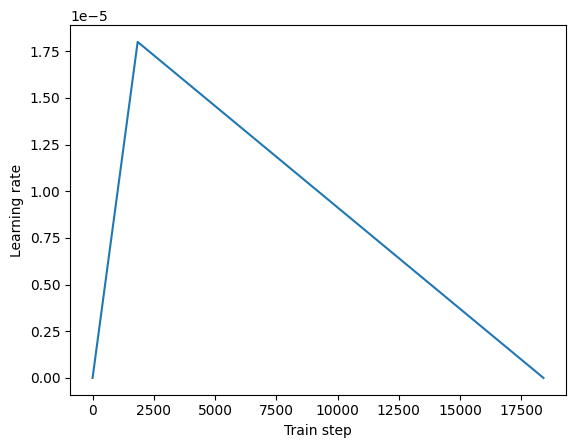

In [7]:
epochs = 3
init_lr = 2e-5
metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy", dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Learning rate schedule
num_train_steps = steps_per_epoch * epochs
warmup_steps = num_train_steps // 10
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    end_learning_rate = 0,
    decay_steps = num_train_steps)
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel("Train step")
plt.ylabel("Learning rate")

# Build model
bert_classifier = build_bert_classifier(num_classes)
optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=warmup_schedule)
bert_classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
bert_classifier.fit(
    train_data,
    validation_data = validation_data,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_steps = validation_steps)

In [8]:
# Save model
preprocessor_save_path = os.path.join(export_dir, "preprocessor")
bert_preprocessor.save(preprocessor_save_path, include_optimizer=False)

classifier_save_path = os.path.join(export_dir, "classifier")
bert_classifier.save(classifier_save_path, include_optimizer=False)

INFO:tensorflow:Assets written to: saved_model/preprocessor/assets


INFO:tensorflow:Assets written to: saved_model/preprocessor/assets


INFO:tensorflow:Assets written to: saved_model/classifier/assets


INFO:tensorflow:Assets written to: saved_model/classifier/assets
